In [545]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import math
import pandas as pd

from enum import Enum


## Enums and Static Values


In [546]:
class BIDDER_TYPE(Enum):
    early = 1
    sniper = 2

In [547]:
new_line = '\n'
new_line_space = '\n' + '   '

## Classes


In [548]:
class Auction:
    def __init__(self, id, N, T, reserve, start_bid):
        self.id = id

        # static values
        self.N = N
        self.T = T
        self.reserve = reserve
        self.start_bid = start_bid
        self.bidders = None

        # dynamic values
        self.t = 0
        self.curr_bid = start_bid

    def __str__(self) -> str:

        attribute_strings = (
            'id: ' + self.id + new_line_space +
            'no. bidders: ' + str(self.N) + new_line_space +
            'duration: ' + str(self.T) + new_line_space +
            'reserve: ' + str(self.reserve) + new_line
        )

        return (
            'Auction(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [549]:

class Bidder:
    def __init__(self, name, risk_coef, wealth_coef, experience_coef, bidder_type, predef_value):
        self.name = name

        # static values
        self.risk_coef = risk_coef  # how much risk is the bidder willing to take?
        self.wealth_coef = wealth_coef  # how wealthy is the bidder?
        self.experience_coef = experience_coef  # how experienced is the bidder?
        self.bidder_type = bidder_type  # early bidder or sniper
        self.predef_value = predef_value  # bidder's estimated value of item pre-auction

        # dynamic values
        self.curr_value = predef_value  # bidders updated in-auction value
        self.is_active = True # all bidders start active

    def __str__(self) -> str:

        attribute_strings = (
            'name: ' + self.name + new_line_space +
            'predef_value: ' + str(self.predef_value) + new_line_space +
            'curr_value: ' + str(self.curr_value) + new_line_space +
            'bidder_type: ' + str(self.bidder_type) + new_line
        )

        return (
            'Bidder(' + new_line_space +
            attribute_strings +
            ')' + new_line
        )


In [550]:
class Bid:
    def __init__(self, amount: int, bidder: Bidder):
        self.amount = amount
        self.bidder = bidder

    def __str__(self) -> str:
        return 'Bid(amount=' + str(self.amount) + ' ,bidder=' + str(self.bidder) + ')'


## Helper Functions


### Distributions

In [551]:
def get_affiliated_pvs(mu, sigma, count):
    # TODO: find more precise distribution
    return np.random.normal(mu, sigma, count)


### Other

In [552]:
def get_bidder_bid(curr_bid: Bid, curr_time: int, bidder: Bidder, duration: int):
    bid_amount = 0

    is_time_to_bid = (
        (bidder.bidder_type == BIDDER_TYPE.early)
        |
        (
            # bids if time 90% of T or bid 90% of value
            (bidder.bidder_type == BIDDER_TYPE.sniper)
            &
            (
                (curr_time > 0.9 * duration)))
        |
        (curr_bid.amount > bidder.curr_value * 0.9)
    )

    # early vs. sniper
    if (is_time_to_bid & (curr_bid.bidder != bidder) & (curr_bid.amount < bidder.curr_value)):
        # bid random btw. current bid and halfway from current bid to own value
        bid_amount = rd.randint(curr_bid.amount, math.floor(
            curr_bid.amount + (bidder.curr_value - curr_bid.amount) / 2))

    return bid_amount


In [553]:

def run_auction(auction):
    auction.curr_bid = auction.start_bid
    auction.t = 0
    no_more_bids = False

    while ((auction.t < auction.T) & (not no_more_bids)):
        bids = []

        for bidder in auction.bidders:
            bid_amount = get_bidder_bid(
                auction.curr_bid, auction.t, bidder, auction.T)

            if (bid_amount > auction.curr_bid.amount):
                bids.append(Bid(bid_amount, bidder))

        if (len(bids) > 0):
            max_bid = max(bids, key=lambda bid: bid.amount)
            auction.curr_bid = max_bid

        else:
            no_more_bids = True

        auction.t += 1

    return auction.curr_bid


In [554]:
def run_simulation(no_iterations):
    # mean and standard deviation of private values
    avg, std = 100, 10
    winning_bids = []
    for i in range(0, no_iterations):
        auction = Auction(id='a'+str(i+1), N=20, T=50,
                          reserve=95, start_bid=Bid(0, None))

        bidder_private_values = get_affiliated_pvs(
            mu=avg, sigma=std, count=auction.N)

        bidders = []
        for i in range(0, auction.N):
            bidders.append(Bidder('b'+str(i+1), 1, 1, 1, rd.choice(
                [BIDDER_TYPE.early, BIDDER_TYPE.sniper]), int(bidder_private_values[i])))

        auction.bidders = bidders

        winning_bids.append(run_auction(auction))

    return winning_bids


## Simulation


In [555]:
winning_bids = run_simulation(1000)


<AxesSubplot: >

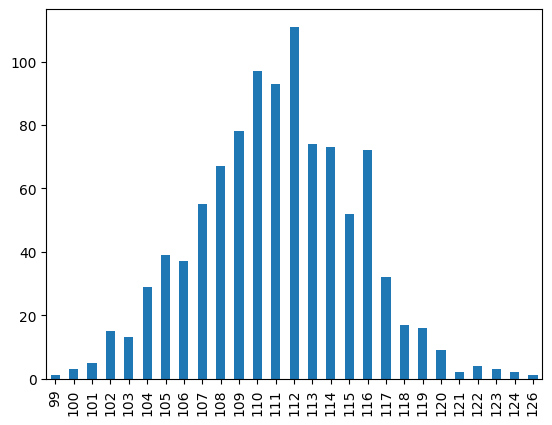

In [556]:

# ---AMOUNT---

winning_bid_amounts = list(map(lambda bid: bid.amount, winning_bids))

sorted_winning_bid_amounts = sorted(winning_bid_amounts)

pd.value_counts(winning_bid_amounts).sort_index().plot.bar()

# plt.plot(sorted_winning_bid_amounts)
# plt.show()


<AxesSubplot: >

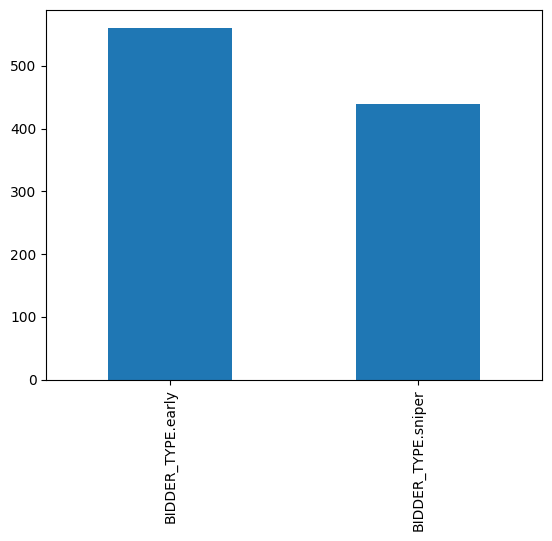

In [557]:
# ---WINNING BIDDER TYPE---

winning_bidder_types = list(
    map(lambda bid: bid.bidder.bidder_type, winning_bids))

pd.value_counts(winning_bidder_types).plot.bar()


<AxesSubplot: >

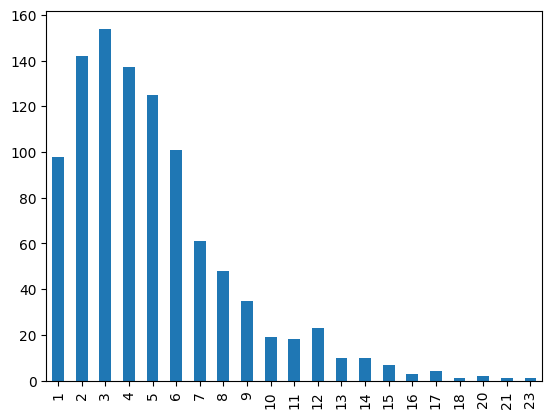

In [558]:
# ---WINNING BIDDER UTILITY---

winning_bidder_utility = list(
    map(lambda bid: bid.bidder.curr_value - bid.amount, winning_bids))

pd.value_counts(winning_bidder_utility).sort_index().plot.bar()
